# 인물사진을 만들어 보자 [프로젝트]

## 목표 

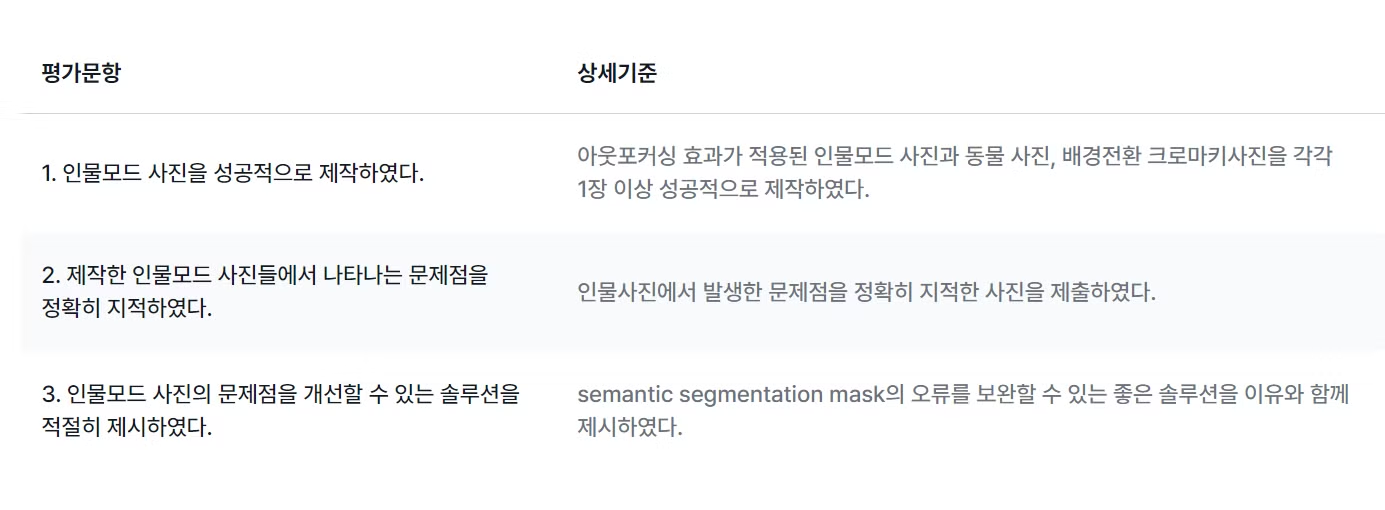


## 목차

#### 결론 요약

생각보다 잘 잡아주지만 사람을 모두 잡아주거나 악세사리를 따로 분류하는것이 흠이었다   

아웃포커싱을 위한 방법으로는 부족하다는 느낌이있다
  
거리에 따라서 사물을 구별해야하는데 객체로써만 분류하는 느낌이 들었다

##### 솔루션
- 모델 학습 시 다른 메트릭 사용
    - 해당 모델에서는 IoU를 사용했다
    - 예측된 영역과 실제 영역의 다른 부분을 강조하는 지표를 사용한다면 더 나아질 수도 있다.
- 다른 모델 사용 : FCN, SegNet, U-Net
- **기존 오류 줄이는 방법**
    - 사진만으로 깊이를 알수있는방법 → 깊이 탐지 딥러닝 기술
    - 카메라에 달린다른 기능을 이용하는 방법 → 적외선 input을 통해 깊이를 탐색하는 방법
- **시멘틱 말고 가장 가까운 인물만을 포커스 해주는 인스턴스 분할 사용**
    - 깊이 탐지 기능을 이용해서 가장가까운 객체에만 아웃포커싱 진행
- **해상도가 낮아서 생기는 문제를 생각해보자**
    - 해상도를 올려주는 기능을 사용하기
    - 추론시 해상도 높은 이미지로 넣자
- **파인튜닝을 이용해서 분류기 부분의 범주를 줄이기**
    - 사람만 분할하게 하던지 등 (ZEP 같이 사람만 보이는 상황)

#### 회고

- 객체를 어떤것을 찾을지에 대해서 우선 사항을 받는 방향으로 기능을 추가할수도있을것같다. 

- 더 많은 데이터에 대해서 한번에 실험하고자 한다면 어떻게 진행해야할까?

- 이번에는 시간이 좀 남아서 이럴때는 어떤것을 진행해야할지 고민해보자 어떤 새로운 실험이있을까?


#### 실험 결과 사진

- 고양이가 모자를 쓰고있는 사진
    - 잔잔한 털을 분할이 잘되지않았다
    - 아웃포커싱을 주려면 악세사리도 같이 분할해야되지않을까?

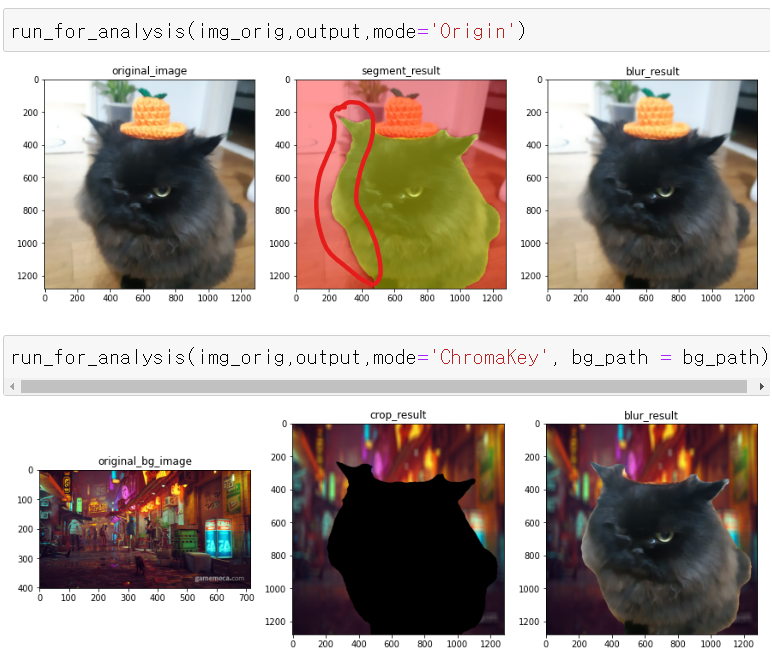

- 여행 사진 - 배경 크로마키가 찌그러짐 - 뒷사람
    - 크로마키는 잘되었지만 배경이 너무 찌그러짐
    - 비율이 잘맞는 크로마키 배경을 선정하자
  
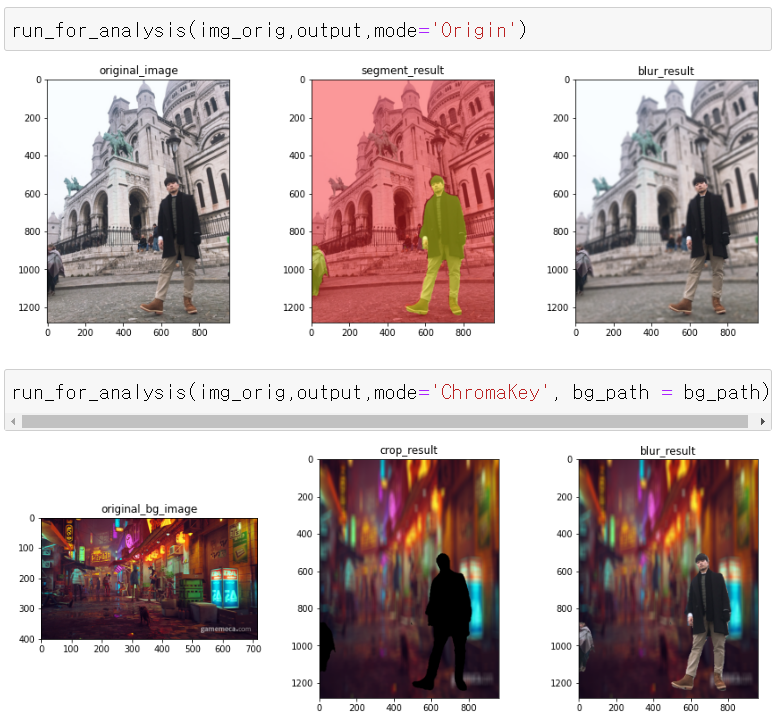

- 카페에서 차를 마시는 사진 - 뒷사람들이 같이나옴
    - 사람의 뒷모습도 잘 인식함 -> 주변사람을 다 인식함
    - 아웃 포커싱에 맞게 하려면 시맨틱말고 인스턴스로 제일 앞에있는 사람만을 놓고 나머지를 블러처리 해야할듯 

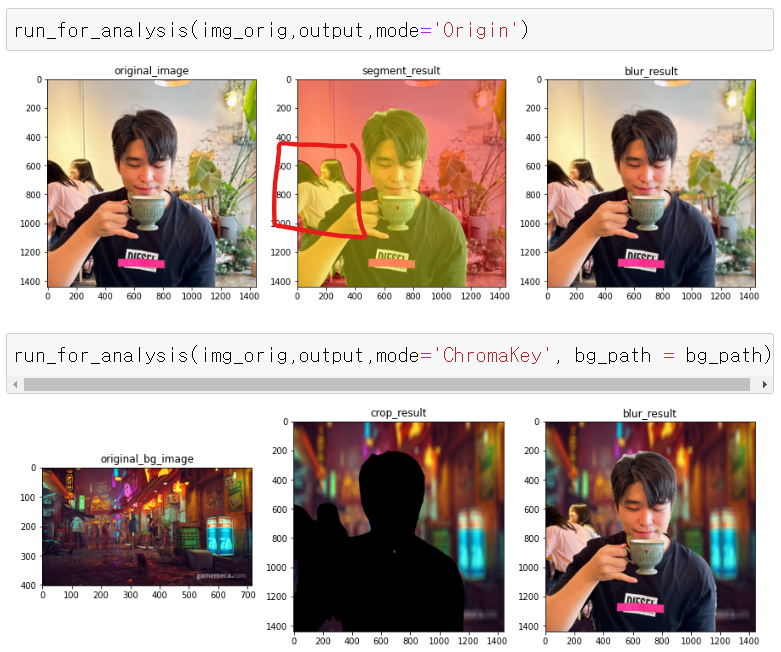

- 강아지를 안고있는 사진 - (아예 분할이 되질않았음) 
    - 마스크를 쓰고있음
    - 강아지와 함께
    - 핸드폰으로 가려짐
  
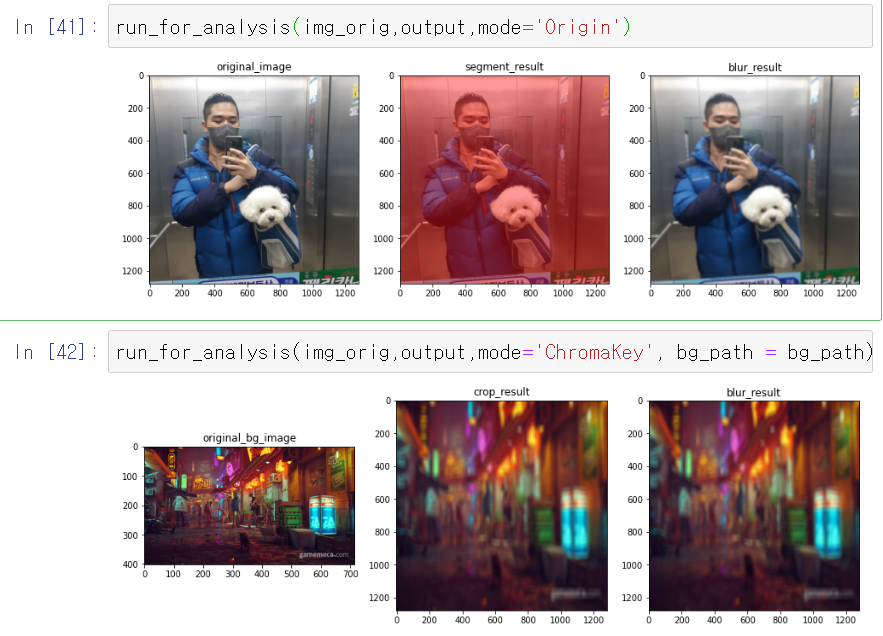

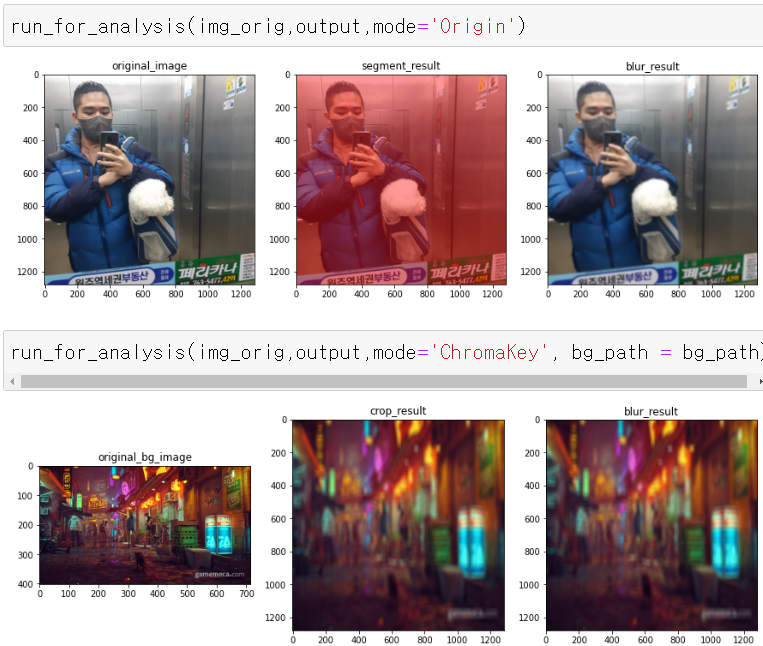

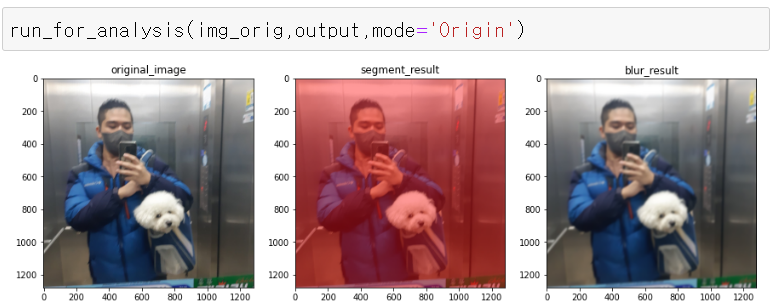



In [58]:
## 라이브러리 호출

import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


In [59]:
# 모델 다운로드

model_dir = 'models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# # 다운로드를 시작합니다 -- 중복 실행 안하게 주석처리함
# urllib.request.urlretrieve(model_url, model_file)

In [60]:
## 함수 설계

# 모델 로드
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

# 컬러맵 제작 - 사람의 컬러맵이 (128,128,192) 인것을 확인했다면 더이상 만들지않아도된다
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
# 사람의 컬러맵 - 자동화 해서 필요없어짐
# seg_color = (128,128,192)

## 사람 마스크 추출
def extper_img(segvalues, output, colormap):
    
    detect_index = segvalues['class_ids'][1]
    colormap[detect_index]
    seg_color = (colormap[detect_index][1], colormap[detect_index][2], colormap[detect_index][0])
    
    seg_map = np.all(output==seg_color, axis=-1) 
    img_mask = seg_map.astype(np.uint8) * 255
    return img_mask

## 블러링 이미지
def blur_img(img_orig):
    img_orig_blur = cv2.blur(img_orig, (13,13))
    return img_orig_blur

## 대상 이미지에서 사람 이미지를 잘라낸 배경
def crop_img(img_mask, img_orig_blur):
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    return img_bg_blur, img_mask_color

## 사진 합치기
def concat_img(img_mask_color, img_orig, img_bg_blur):
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    return img_concat

def run(img_orig,output,mode='Origin',bg_path=None):
    if mode == 'Origin':
        img_mask = extper_img(segvalues, output, colormap)
        #오리진 이미지 블러 처리
        img_orig_blur = blur_img(img_orig)
        img_bg_blur, img_mask_color = crop_img(img_mask, img_orig_blur)
        img_concat = concat_img(img_mask_color, img_orig, img_bg_blur)
    
        ## 크롭된 사진 추출용
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()
    
    ## 배경을 바꾸고 싶은 모드에서 사용함
    elif mode == 'ChromaKey':
        bg_orig = cv2.imread(bg_path)
        img_mask = extper_img(segvalues, output, colormap)
        
        #배경사진 이미지 블러 처리
        bg_orig_blur = blur_img(bg_orig)
        
        x = img_mask.shape[0]
        y = img_mask.shape[1]
        bg_orig_resize = cv2.resize(bg_orig_blur,(y,x))
        
        img_bg_blur, img_mask_color = crop_img(img_mask, bg_orig_resize)
        
        
        img_concat = concat_img(img_mask_color, img_orig, img_bg_blur)
    
        ## 크롭된 사진 추출용
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()
        

def run_for_analysis(img_orig,output,mode='origin',bg_path=None):
    if mode == 'Origin':
        img_show = img_orig.copy() # copy for visualize
        
        img_mask = extper_img(segvalues, output, colormap)
        #오리진 이미지 블러 처리
        img_orig_blur = blur_img(img_orig)
        img_bg_blur, img_mask_color = crop_img(img_mask, img_orig_blur)
        img_concat = concat_img(img_mask_color, img_orig, img_bg_blur)
        
        # 시각화 코드
        color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_AUTUMN)
        # 원본 이미지와 마스트를 적당히 합쳐봅니다
        # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
        img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
        
        fig, axs = plt.subplots(1,3, figsize=(15,5))
        
        # 원본 시각화
        axs[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
        axs[0].set_title("original_image")
        # 세그멘트 시각화
        axs[1].imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
        axs[1].set_title("segment_result")
        ## 결과
        axs[2].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        axs[2].set_title("blur_result")
    
    ## 배경을 바꾸고 싶은 모드에서 사용함
    elif mode == 'ChromaKey':
        bg_orig = cv2.imread(bg_path)
        img_mask = extper_img(segvalues, output, colormap)
        
        #배경사진 이미지 블러 처리
        bg_orig_blur = blur_img(bg_orig)
        
        x = img_mask.shape[0]
        y = img_mask.shape[1]
        bg_orig_resize = cv2.resize(bg_orig_blur,(y,x))
        
        img_bg_blur, img_mask_color = crop_img(img_mask, bg_orig_resize)
        
        img_concat = concat_img(img_mask_color, img_orig, img_bg_blur)
  
        fig, axs = plt.subplots(1,3, figsize=(15,5))
        
        # 원본 시각화
        axs[0].imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
        axs[0].set_title("original_bg_image")
        # 세그멘트 시각화
        axs[1].imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
        axs[1].set_title("crop_result")
        ## 결과
        axs[2].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        axs[2].set_title("blur_result")
    

# 실행 위치

In [66]:
## 사용할 이미지 로드

# animal_example01.jpg
img_path = 'data/photo_example05.jpg' 
bg_path = 'data/bg_example01.jpg'
# 원본 이미지 로드
img_orig = cv2.imread(img_path)
# 모델 사용
segvalues, output = model.segmentAsPascalvoc(img_path)

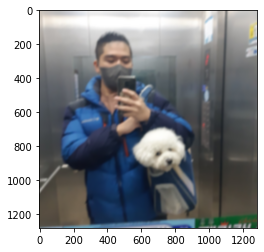

In [67]:
run(img_orig,output,mode='Origin')

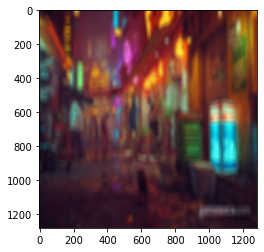

In [68]:
run(img_orig,output,mode='ChromaKey', bg_path = bg_path)

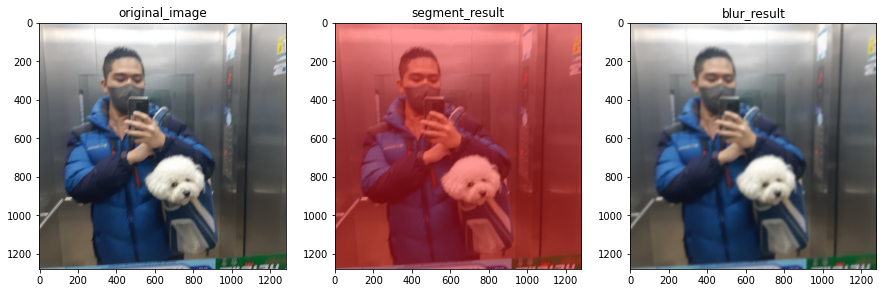

In [69]:
run_for_analysis(img_orig,output,mode='Origin')

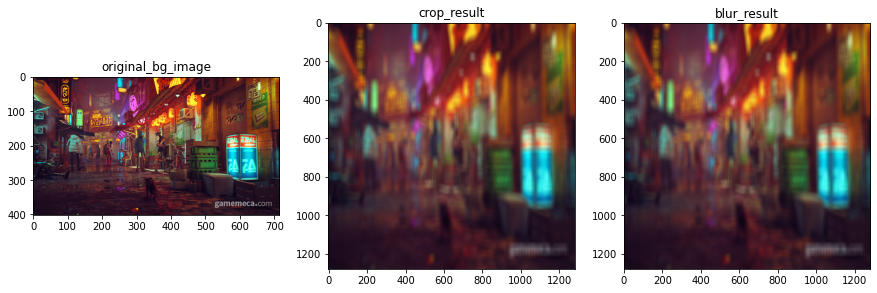

In [70]:
run_for_analysis(img_orig,output,mode='ChromaKey', bg_path = bg_path)

# 여기서부터 실습 노트북

(1440, 1440, 3)


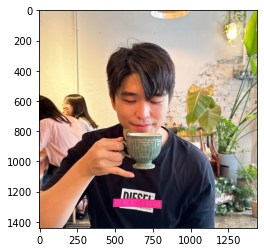

In [16]:
# bg_example01.jpg
# animal_example01.jpg
# photo_example01.jpg

img_path = 'data/photo_example01.jpg' 

img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
model_dir = 'models'

model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다 - 중복 실행 X
# urllib.request.urlretrieve(model_url, model_file)

('models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7cb01d3b54f0>)

In [18]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [19]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

### 데이터의 라벨값

1=aeroplane, 2=bicycle, 3=bird,   4=boat, 5=bottle, 6=bus,   7=car , 8=cat, 9=chair,   10=cow, 11=diningtable, 12=dog,   13=horse, 14=motorbike, 15=person,   16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor  
  
15= 사람 16 = potted plant

In [20]:
output

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[128, 128, 192],
        [128, 128, 192],
        [128, 128, 192],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128, 128, 192],
        [128, 128, 192],
        [128, 128, 192],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128, 128, 192],
        [128, 128, 192],
        [128, 128, 192],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

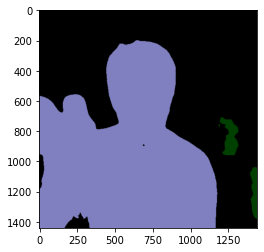

In [21]:
plt.imshow(output)
plt.show()

## 컬러맵 만들기

어떻게 만드는건지는 모르겠지만 255개의 랜덤한 컬러맵을 만들어주는 코드다  

8비트씩 움직이며 랜덤한 컬러를 만들어준다  

왜인지 모르겠지만 PASCAL VOC의 라벨과 동일하게 라벨링이 되어있는듯  

예를들어 만들어진 컬러맵 15번째와 모델에서 나온 output의 15번째 사람을 나타내는 색깔이 같은 값을 가진다. 

따라서 사람만을 검출하고싶을때 15번째 색깔과 같은 픽셀만을 가져온다.

In [22]:
#컬러맵 만들기 

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [23]:
colormap[15]

array([192, 128, 128])

In [24]:
seg_color = (128,128,192)

# 컬러맵 인덱싱 자동화 노트

매번 사람이 아닌 객체를 탐지할때도 컬러맵을 일일히 찾아서 바꿔줘야하는 어려움이있다.  
  
segvalues에서 index를 받아서 자동으로 컬러맵을 찾아주는 방법을 생각해보자  
  
하지만  여러 객체를 탐지했다면 그중에 어떤것을 남길지를 어떻게 알수있을까??

1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle, 6=bus, 7=car , 8=cat, 9=chair, 10=cow, 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person, 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
  
우리가 원하는 index를 어떻게 알수있을까?미리 설정을 하고들어가야하나
  
우리가 원하는 객체는 사람 또는 동물
  
3, 8, 10, 12, 13, 15, 17 이 아니라면 다 버리는 방법을 사용하자

In [25]:
detect_index = segvalues['class_ids'][1]
colormap[detect_index]

seg_color = (colormap[detect_index][1], colormap[detect_index][2], colormap[detect_index][0])
seg_color

(128, 128, 192)

In [26]:
output.shape

(1440, 1440, 3)

(1440, 1440)


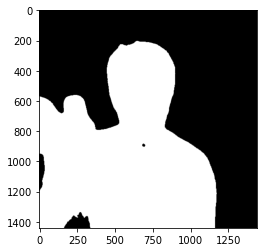

In [27]:
# seg_color와 일치하는 픽셀만을 Ture로 남긴다 
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

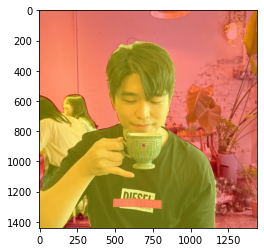

In [28]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
# 잘안보여서 원래 JET 컬러맵을 AUTUMN으로 바꿨다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_AUTUMN)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

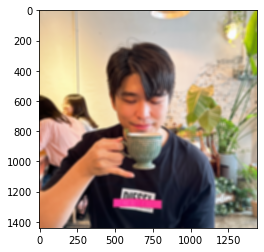

In [29]:

img_orig_blur = cv2.blur(img_orig, (20,20))

 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

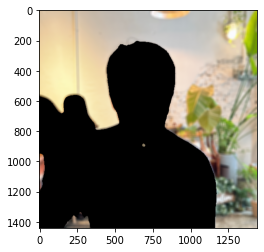

In [30]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

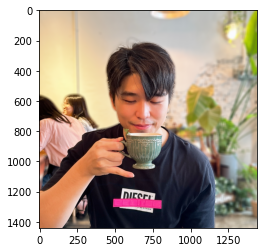

In [31]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()